# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «~~название засекреченно~~»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Откроем файл с данными и изучим общую информацию

##### Импорты:

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt

##### Датасеты:

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

pd.set_option('display.max_columns', None)

##### calls (информация о звонках):

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

##### internet (информация об интернет-сессиях):

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

##### messages (информация о сообщениях):

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

##### tariffs (информация о тарифах):

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

##### users (информация о пользователях):

In [10]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
#переименуем столбец tarriff_name в tariff, чтобы потом объеденить таблицы по этим столбцам
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

#### Вывод:

Данные выглядят полными и чистыми, где есть пропуски - они обоснованы.
- Таблицы calls, internet и messages можно соединить по столбцу 'id'
- Таблицы users и tariffs можно соединить по столбцу 'user_id'
- Нужно преобразовать даты в формат datetime.
- Следует проверить таблицы на наличие выбросов.

### Шаг 2. Подготовим данные

### 2.1 Предобработка данных

Соеденим все таблицы в один датафрейм

In [13]:
merged_calls_messages = pd.merge(calls, messages, on='id', how='left')
merged_calls_messages_internet = pd.merge(merged_calls_messages, internet, on='id', how='left')
merged_calls_messages_internet_users = pd.merge(merged_calls_messages_internet, users, on='user_id', how='left')

clients = pd.merge(merged_calls_messages_internet_users, tariffs, on='tariff', how='left')
clients.head()

,id,call_date,duration,user_id_x,message_date,user_id_y,Unnamed: 0,mb_used,session_date,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000_0,2018-07-25,0.00,1000,2018-06-27,1000.0,0.0,112.95,2018-11-25,1000.0,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
1,1000_1,2018-08-17,0.00,1000,2018-10-08,1000.0,1.0,1052.81,2018-09-07,1000.0,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
2,1000_2,2018-06-11,2.85,1000,2018-08-04,1000.0,2.0,1197.26,2018-06-25,1000.0,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
3,1000_3,2018-09-21,13.80,1000,2018-06-16,1000.0,3.0,550.27,2018-08-22,1000.0,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
4,1000_4,2018-12-15,5.18,1000,2018-12-05,1000.0,4.0,302.56,2018-09-24,1000.0,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0


Странный столбец 'Unnamed: 0'. Непонятно, по какому принципу в нем записаны значения. Возможно, что это какая-то ошибка при выгрузке данных. Не думаю, что в нашем анализе этот столбец будет задействован, поэтому можно его откинуть.

In [14]:
clients = clients.drop(columns='Unnamed: 0')

Приведем все столбцы с датами к формату datetime:

In [15]:
clients['call_date'] = pd.to_datetime(clients['call_date'], format='%Y-%m-%d')
clients['message_date'] = pd.to_datetime(clients['message_date'], format='%Y-%m-%d')
clients['session_date'] = pd.to_datetime(clients['session_date'], format='%Y-%m-%d')
clients['churn_date'] = pd.to_datetime(clients['churn_date'], format='%Y-%m-%d')
clients['reg_date'] = pd.to_datetime(clients['reg_date'], format='%Y-%m-%d')

### 2.2 Выявление ошибок

Компания всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. В связи с этим могут возьникнуть выбросы ввиде большого кол-ва нулей. Проверим это посмотрив гистограммы.

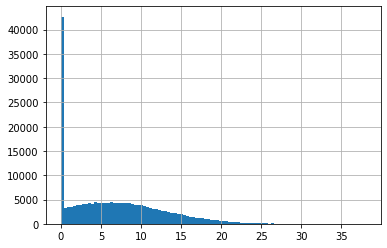

In [16]:
clients.duration.hist(bins=100);

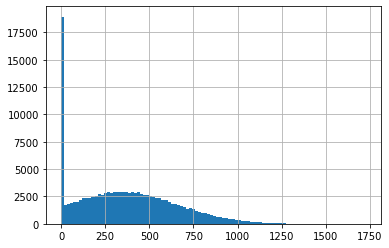

In [17]:
clients.mb_used.hist(bins=100);

Сохраним срез, где данные в 'duration' и 'mb_used' будут начинаться с 1

In [18]:
clients = clients.query('duration >= 1 and mb_used >= 1')

### 2.3 Добавление столбцов

Посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [19]:
#создадим столбец с месяцем из даты звонка
clients['month'] = pd.DatetimeIndex(clients['call_date']).month_name()
#столбец с полным именем пользователя
clients['full_name'] = clients[['first_name', 'last_name']].agg(' '.join, axis=1)

##### Таблица количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:

In [20]:
clients_calls =(clients
    .pivot_table(index=('user_id','full_name', 'month'), values='duration', aggfunc=('count', 'sum'))
    .rename(columns={'count': 'calls', 'sum': 'minutes'}))
clients_calls

calls  minutes
user_id full_name        month                    
1000.0  Рафаил Верещагин August        26   250.92
                         December      18   152.67
                         July          26   217.45
                         June          13    77.97
                         May            6    59.99
...                                   ...      ...
1498.0  Всеволод Акимчин September     41   375.79
1499.0  Гектор Корнилов  December      21   206.57
                         November      42   415.56
                         October       19   214.68
                         September      5    51.63

[3153 rows x 2 columns]

##### Таблица количества отправленных сообщений по месяцам для каждого пользователя:

In [21]:
clients_messages =(clients
                   .pivot_table(index=('user_id','full_name', 'month'), values='id', aggfunc='count')
                   .rename(columns={'id': 'messages'}))
clients_messages

messages
user_id full_name        month              
1000.0  Рафаил Верещагин August           26
                         December         18
                         July             26
                         June             13
                         May               6
...                                      ...
1498.0  Всеволод Акимчин September        41
1499.0  Гектор Корнилов  December         21
                         November         42
                         October          19
                         September         5

[3153 rows x 1 columns]

##### Таблица объема израсходованного интернет-трафика по месяцам для каждого пользователя:

In [22]:
clients_mb =(clients
             .pivot_table(index=('user_id','full_name', 'month'), values='mb_used', aggfunc='sum')
             .rename(columns={'mb_used': 'mb_used_sum'}))
clients_mb

mb_used_sum
user_id full_name        month                 
1000.0  Рафаил Верещагин August        15410.77
                         December      10093.04
                         July          11330.30
                         June           7882.73
                         May            3202.25
...                                         ...
1498.0  Всеволод Акимчин September     16984.93
1499.0  Гектор Корнилов  December       7765.29
                         November      17597.22
                         October        7636.28
                         September      1709.16

[3153 rows x 1 columns]

##### Помесячная выручка с каждого пользователя

In [23]:
#сборная таблица urevenue - user revenue (выручка с пользователя)
urevenue = (clients_calls
         .merge(clients_mb, on=('user_id','full_name', 'month'), how='left')
         .merge(clients_messages, on=('user_id', 'full_name', 'month'), how='left')
         .reset_index())
#датафрейм с пользователями и тарифами
urevenue_full = (urevenue
         .merge(users, on='user_id', how='left')
         .merge(tariffs, on='tariff', how='left'))

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика:

In [24]:
urevenue_full['minutes_over']  = urevenue_full['minutes'] - urevenue_full['minutes_included']
urevenue_full['messages_over'] = urevenue_full['messages'] - urevenue_full['messages_included']
urevenue_full['mb_used_over']  = urevenue_full['mb_used_sum'] - urevenue_full['mb_per_month_included']

Остаток умножим на значение из тарифного плана:

In [25]:
def monthly_overpayment(row):
    minutes = 0
    messages = 0
    mb_used = 0
    if row['minutes_over'] > 0:
        minutes = row['minutes_over'] * row['rub_per_minute']
    if row['messages_over'] > 0:
        messages = row['messages_over'] * row['rub_per_message']
    if row['mb_used_over'] > 0:
        mb_used = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    return minutes + messages + mb_used

urevenue_full['rub_monthly_fee_over'] = urevenue_full.apply(monthly_overpayment, axis=1)

Прибавим абонентскую плату, соответствующую тарифному плану:

In [26]:
urevenue_full['rub_monthly_fee_total'] = urevenue_full['rub_monthly_fee'] + urevenue_full['rub_monthly_fee_over']

Датафрейм без лишних данных

In [27]:
urevenue_full = pd.DataFrame(
    urevenue_full[['user_id','tariff', 'month', 'city', 'calls',
                   'minutes', 'messages', 'mb_used_sum', 'minutes_over',
                  'messages_over', 'mb_used_over', 'rub_monthly_fee_over',
                  'rub_monthly_fee_total']])
urevenue_full.head()

,user_id,tariff,month,city,calls,minutes,messages,mb_used_sum,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1000.0,ultra,August,Краснодар,26,250.92,26,15410.77,-2749.08,-974,-15309.23,0.0,1950.0
1,1000.0,ultra,December,Краснодар,18,152.67,18,10093.04,-2847.33,-982,-20626.96,0.0,1950.0
2,1000.0,ultra,July,Краснодар,26,217.45,26,11330.30,-2782.55,-974,-19389.70,0.0,1950.0
3,1000.0,ultra,June,Краснодар,13,77.97,13,7882.73,-2922.03,-987,-22837.27,0.0,1950.0
4,1000.0,ultra,May,Краснодар,6,59.99,6,3202.25,-2940.01,-994,-27517.75,0.0,1950.0


### Шаг 3. Проанализируйте данные

Исходя из выборки, опишем поведение клиентов оператора. Узнаем, сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [28]:
urevenue_full_smart = urevenue_full.query('tariff == "smart"')
urevenue_full_smart.pivot_table(index=('tariff', 'month'), values = ('minutes', 'messages', 'mb_used_sum'))

mb_used_sum   messages     minutes
tariff month                                         
smart  April       9296.129369  24.513514  216.031171
       August     11253.392521  29.038462  258.757735
       December   12388.545493  32.226866  286.640955
       February    7372.049310  19.155172  171.532414
       January     5555.241515  13.969697  127.659394
       July       11057.553250  28.655000  253.532550
       June       10570.689080  27.447853  242.545460
       March       9901.620649  25.584416  226.027403
       May        10031.376929  26.042857  227.582000
       November   11571.314190  29.812698  262.570159
       October    11208.469898  29.174061  256.706928
       September  11477.530425  29.575290  260.260309

In [29]:
urevenue_full_ultra = urevenue_full.query('tariff == "ultra"')
urevenue_full_ultra.pivot_table(index=('tariff', 'month'), values = ('minutes', 'messages', 'mb_used_sum'))

mb_used_sum   messages     minutes
tariff month                                         
ultra  April      12006.849057  22.169811  192.701132
       August     13649.375149  25.603960  223.339802
       December   15029.865530  28.181818  251.588485
       February    8618.845455  16.272727  145.028636
       January    10735.457778  19.777778  172.073333
       July       14500.603953  26.941860  235.682674
       June       12910.144051  24.164557  210.066962
       March      12220.497838  23.135135  207.286486
       May        13688.286667  25.857143  228.766984
       November   13893.312109  26.171875  234.533984
       October    14254.175983  26.521368  239.411966
       September  13638.203981  25.814815  228.380278

### Минуты

In [30]:
urevenue_full_ultra['minutes'].describe()

count    935.000000
mean     227.125123
std      123.462839
min        1.980000
25%      135.300000
50%      221.630000
75%      304.365000
max      664.940000
Name: minutes, dtype: float64

In [31]:
urevenue_full_smart['minutes'].describe()

count    2218.000000
mean      252.278760
std       106.000122
min         1.780000
25%       183.845000
50%       251.715000
75%       325.317500
max       811.210000
Name: minutes, dtype: float64

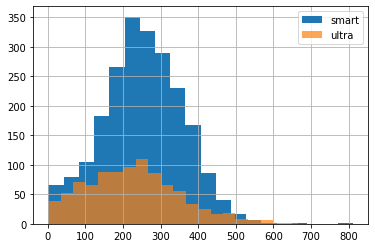

In [32]:
urevenue_full_smart['minutes'].hist(bins=20, label='smart')
urevenue_full_ultra['minutes'].hist(bins=20, label='ultra', alpha=0.7)
plt.legend(loc=1);

In [33]:
urevenue_full_smart['minutes'].std()
print('Тариф "Смарт"')
print('Стандартное отклонение:', np.std(urevenue_full_smart['minutes']))
print('Дисперсия:', np.var(urevenue_full_smart['minutes']))

Тариф "Смарт"
Стандартное отклонение: 105.97622388444216
Дисперсия: 11230.96002880541


In [34]:
urevenue_full_ultra['minutes'].std()
print('Тариф "Ультра"')
print('Стандартное отклонение:', np.std(urevenue_full_ultra['minutes']))
print('Дисперсия:', np.var(urevenue_full_ultra['minutes']))

Тариф "Ультра"
Стандартное отклонение: 123.3967983150156
Дисперсия: 15226.769834396637


##### Вывод:

Из графика видно, что в среднем пользователи тарифа "Смарт" укладываются в лимит по минутам и изредка заходят за предел, также, как и пользователи тарифа "Ультра".

### Сообщения

In [35]:
urevenue_full_ultra['messages'].describe()

count    935.000000
mean      25.635294
std       13.583379
min        1.000000
25%       15.000000
50%       25.000000
75%       35.000000
max       68.000000
Name: messages, dtype: float64

In [36]:
urevenue_full_smart['messages'].describe()

count    2218.000000
mean       28.541028
std        11.566262
min         1.000000
25%        21.000000
50%        29.000000
75%        36.000000
max        86.000000
Name: messages, dtype: float64

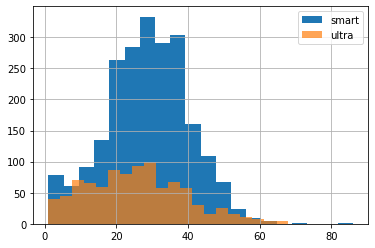

In [37]:
urevenue_full_smart['messages'].hist(bins=20, label='smart')
urevenue_full_ultra['messages'].hist(bins=20, label='ultra', alpha=0.7)
plt.legend(loc=1);

In [38]:
urevenue_full_smart['messages'].std()
print('Тариф "Смарт"')
print('Стандартное отклонение:', np.std(urevenue_full_smart['messages']))
print('Дисперсия:', np.var(urevenue_full_smart['messages']))

Тариф "Смарт"
Стандартное отклонение: 11.563654669394742
Дисперсия: 133.71810931301482


In [39]:
urevenue_full_ultra['messages'].std()
print('Тариф "Ультра"')
print('Стандартное отклонение:', np.std(urevenue_full_ultra['messages']))
print('Дисперсия:', np.var(urevenue_full_ultra['messages']))

Тариф "Ультра"
Стандартное отклонение: 13.576112841559503
Дисперсия: 184.31083988675684


Из графика видно, что пользователи обоих тарифов в среднем пишут по 20-40 сообщений в месяц, тогда как пользователи "Смарт" изредка могут выходить за лимит в 50 сообщений. 

### Объем трафика

In [40]:
urevenue_full_ultra['mb_used_sum'].describe()

count      935.000000
mean     13674.447305
std       7427.473142
min        133.950000
25%       8116.355000
50%      13522.020000
75%      18310.085000
max      38826.930000
Name: mb_used_sum, dtype: float64

In [41]:
urevenue_full_smart['mb_used_sum'].describe()

count     2218.000000
mean     11014.114220
std       4610.218206
min         27.190000
25%       7912.627500
50%      11058.405000
75%      14133.292500
max      33142.490000
Name: mb_used_sum, dtype: float64

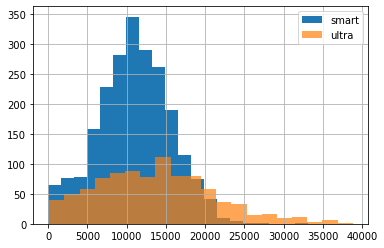

In [42]:
urevenue_full_smart['mb_used_sum'].hist(bins=20, label='smart')
urevenue_full_ultra['mb_used_sum'].hist(bins=20, label='ultra', alpha=0.7)
plt.legend(loc=1);

In [43]:
urevenue_full_smart['mb_used_sum'].std()
print('Тариф "Смарт"')
print('Стандартное отклонение:', np.std(urevenue_full_smart['mb_used_sum']))
print('Дисперсия:', np.var(urevenue_full_smart['mb_used_sum']))

Тариф "Смарт"
Стандартное отклонение: 4609.1788147941015
Дисперсия: 21244529.346746758


In [44]:
urevenue_full_ultra['mb_used_sum'].std()
print('Тариф "Ультра"')
print('Стандартное отклонение:', np.std(urevenue_full_ultra['mb_used_sum']))
print('Дисперсия:', np.var(urevenue_full_ultra['mb_used_sum']))

Тариф "Ультра"
Стандартное отклонение: 7423.500168986996
Дисперсия: 55108354.75894996


##### Вывод:

Из графика видно, что пользователям "Смарт" в большинстве своем укладываются в лимит 15гб. хоть и часто переплачивают за дополнительный объем. Пользователи "Ультра" редко превышают лимит.

### Шаг 4. Проверьте гипотезы

Проведем статистические тесты методом Стьюдента (сравнение среднего двух выборок), чтобы понять, различается ли средняя выручка пользователей двух тарифов, а также средняя выручка для пользователей Москвы и других областей.

Критический уровень статистической значимости alpha примем за 0.05%

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [45]:
print('Средняя выручка пользователей тарифов «Ультра»:', urevenue_full_ultra['rub_monthly_fee_total'].mean().round())
print('Средняя выручка пользователей тарифов «Смарт»:', urevenue_full_smart['rub_monthly_fee_total'].mean().round())

Средняя выручка пользователей тарифов «Ультра»: 1960.0
Средняя выручка пользователей тарифов «Смарт»: 633.0


- H0 = Средняя выручка пользователей тарифов  «Ультра» и «Смарт» не различается
- H1 = Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [46]:
alpha = 0.05
results = st.ttest_ind(urevenue_full_smart['rub_monthly_fee_total'], urevenue_full_ultra['rub_monthly_fee_total'])
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


##### Вывод:

Нулевая гипотеза отверглась. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [47]:
moscow = urevenue_full.query('city == "Москва"')
other = urevenue_full.query('city != "Москва"')
print('Средняя выручка пользователей из Москвы:', moscow['rub_monthly_fee_total'].mean().round())
print('Средняя выручка пользователей из других регионов:', other['rub_monthly_fee_total'].mean().round())

Средняя выручка пользователей из Москвы: 1120.0
Средняя выручка пользователей из других регионов: 1004.0


- H0 = Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1 = Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [48]:
alpha = 0.05
results = st.ttest_ind(moscow['rub_monthly_fee_total'], other['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.694951152498098e-05
Отвергаем нулевую гипотезу


##### Вывод: 

Нулевая гипотеза отверглась. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

### Шаг 5. Общий вывод

Какой тариф лучше? При сравнение средних выручек тарифов "Ультра" и "Смарт" видно, что тариф "Ультра" приносит большую выручку.
 
Пользователи "Смарт" часто переплачивают за объем трафика. Возможно стоит пересмотреть эту позицию в тарифе и увеличить лимит.